In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('../')
print(sys.path)

['/home/hieutt/UniCon_EnetV2_OpenMax/notebooks', '/home/hieutt/miniconda3/envs/torchtf/lib/python39.zip', '/home/hieutt/miniconda3/envs/torchtf/lib/python3.9', '/home/hieutt/miniconda3/envs/torchtf/lib/python3.9/lib-dynload', '', '/home/hieutt/miniconda3/envs/torchtf/lib/python3.9/site-packages', '../']


In [2]:
import os
import torch
import numpy as np
import pickle
import torch.nn.functional as F
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix, f1_score, precision_score, recall_score, accuracy_score
from sklearn.manifold import TSNE

from dataset import CANDatasetEnet as CANDataset
from representation.MPNCOV import MPNCOV
from representation.GAvP import GAvP
from representation.BCNN import BCNN
from representation.CBP import CBP
from rd_openmax import openmax_predict_rd
from model_init import *
from torchvision import transforms
from torch.utils.data import DataLoader


In [3]:
seed = 1
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

In [4]:
# Configuration
# /home/hieutt/UniCon_EnetV2_OpenMax/save/CAN_TT_models/UniCon/UniCon_CAN_TT_mpncovresnet34_lr_0.05_decay_0.0001_bsz_256_trial_6_cosine_warm
ckpt_path = "../save/CAN_TT_models/UniCon/UniCon_CAN_TT_mpncovresnet34_lr_0.05_decay_0.0001_bsz_256_trial_6_cosine_warm/ckpt_epoch_100.pth"
weibull_path = ckpt_path.replace("ckpt_epoch_100.pth", "weibull_epoch_100.pkl")
data_close = "../data/set_04/test_01_known_vehicle_known_attack/preprocessed/5_percent/TFRecord_w64_s32/2"
data_open = "../data/set_04/test_03_known_vehicle_unknown_attack/preprocessed/TFRecord_w64_s32/2"
device = torch.device("cuda:0")
n_classes = 6
from representation.MPNCOV import MPNCOV  # hoặc import đúng nơi chứa lớp này

representation = {
    'function': MPNCOV,
    'iterNum': 5,
    'is_sqrt': True,
    'is_vec': True,
    'input_dim': 128,
    'dimension_reduction': 64
}
batch_size = 256
attention = 'Cov'

In [5]:
# Load model
print("representation = ", representation)
print("type = ", type(representation))

# 1. Khởi tạo model
model = get_model(
    'mpncovresnet34',
    representation,
    n_classes,
    input_size=64,
    attention=attention
)

def load_checkpoint_remove_module(filename):
    checkpoint = torch.load(filename, weights_only=False)
    state_dict = checkpoint['model']
    new_state_dict = {k.replace('module.', ''): v for k, v in state_dict.items()}
    return new_state_dict

model.load_state_dict(load_checkpoint_remove_module(ckpt_path))
model = model.to(device)
model.eval()

# 3. Load Weibull models
with open(weibull_path, 'rb') as f:
    weibull_data = pickle.load(f)
class_means = weibull_data['class_means']
weibull_models = weibull_data['weibull_models']


representation =  {'function': <class 'representation.MPNCOV.MPNCOV'>, 'iterNum': 5, 'is_sqrt': True, 'is_vec': True, 'input_dim': 128, 'dimension_reduction': 64}
type =  <class 'dict'>
Using tiny size model: mpncovresnet34tiny!


/home/hieutt/UniCon_EnetV2_OpenMax/notebooks/../networks/base.py:13: UserWarning: You will use model that randomly initialized!
  warn.warn('You will use model that randomly initialized!')


FileNotFoundError: [Errno 2] No such file or directory: '../save/CAN_TT_models/UniCon/UniCon_CAN_TT_mpncovresnet34_lr_0.05_decay_0.0001_bsz_256_trial_6_cosine_warm/ckpt_epoch_100.pth'

In [6]:
# Load datasets
transform = transforms.Compose([
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
close_set = CANDataset(root_dir=data_close, window_size=32, is_train=False, transform=transform)
open_set = CANDataset(root_dir=data_open, window_size=32, is_train=False, transform=transform)

close_loader = torch.utils.data.DataLoader(close_set, batch_size=batch_size, shuffle=False)
open_loader = torch.utils.data.DataLoader(open_set, batch_size=batch_size, shuffle=False)


In [16]:
# Collect features + unk_prob + true label từ dataset
def collect_scores(loader):
    features, scores, labels = [], [], []
    with torch.no_grad():
        for x, y in tqdm(loader):
            x = x.to(device)
            feat = F.normalize(model(x), dim=1).cpu().numpy()
            y = y.numpy()
            for f, label in zip(feat, y):
                _, unk = openmax_predict_rd(f, class_means, weibull_models)
                features.append(f)
                scores.append(unk)
                labels.append(label)
    return np.array(features), np.array(scores), np.array(labels)

feat_open, score_open, label_open = collect_scores(open_loader)

known_class = 0
labels_binary = np.array([0 if y == known_class else 1 for y in label_open])

all_feat = feat_open
all_scores = score_open
all_labels_true = label_open
all_labels_binary = labels_binary


100%|██████████| 168/168 [02:24<00:00,  1.16it/s]


Best threshold: 0.8152, AUC: 0.8208


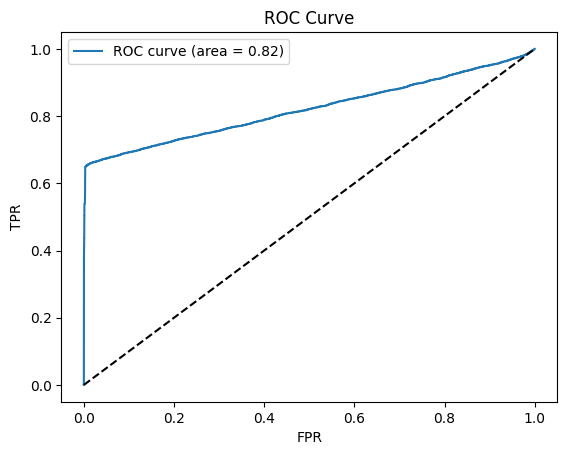

In [17]:
# ROC curve
fpr, tpr, thresholds = roc_curve(all_labels_binary, all_scores)
auc = roc_auc_score(all_labels_binary, all_scores)
best_idx = np.argmax(tpr - fpr)
best_thresh = thresholds[best_idx]
print(f"Best threshold: {best_thresh:.4f}, AUC: {auc:.4f}")
plt.figure()
plt.plot(fpr, tpr, label=f"ROC curve (area = {auc:.2f})")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC Curve')
plt.legend()
plt.show()

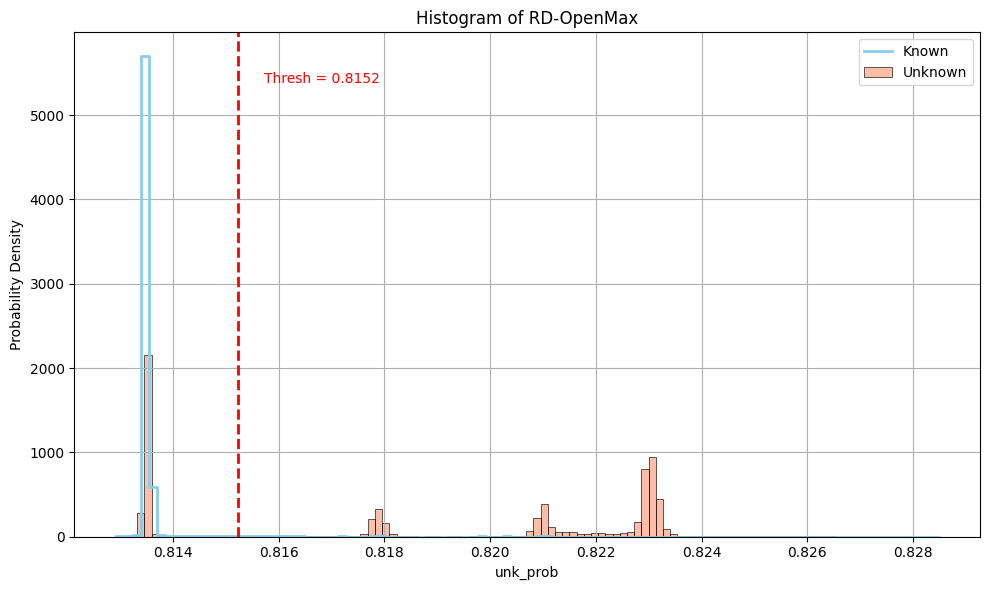

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# Dữ liệu
unk_known = all_scores[all_labels_binary == 0]
unk_unknown = all_scores[all_labels_binary == 1]

# Tạo plot
plt.figure(figsize=(10, 6))

# Known: dạng step, alpha nhỏ
sns.histplot(unk_known, bins=100, color='skyblue', stat='density',
             element='step', label='Known', fill=False, linewidth=2)

# Unknown: bar đậm
sns.histplot(unk_unknown, bins=100, color='coral', stat='density',
             element='bars', label='Unknown', alpha=0.5)

# Vẽ threshold
plt.axvline(best_thresh, color='red', linestyle='--', linewidth=2)
plt.text(best_thresh + 0.0005, plt.ylim()[1]*0.9,
         f'Thresh = {best_thresh:.4f}', color='red')

# Hiệu chỉnh trục để thấy phần chồng lấn
# plt.xlim(0.86, 0.895)

# Giao diện
plt.title("Histogram of RD-OpenMax")
plt.xlabel("unk_prob")
plt.ylabel("Probability Density")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()




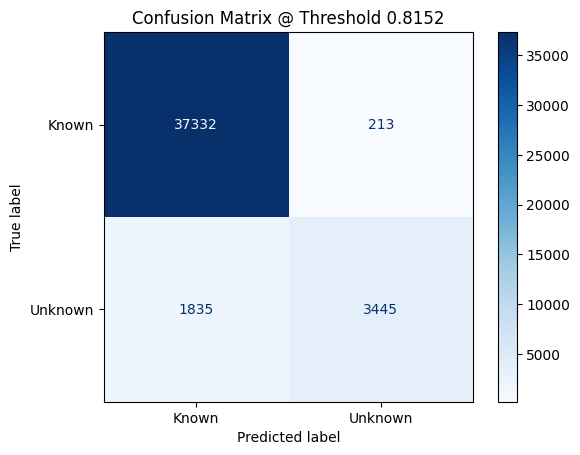

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

preds = (all_scores >= best_thresh).astype(int)
cm = confusion_matrix(all_labels_binary, preds)
disp = ConfusionMatrixDisplay(cm, display_labels=['Known', 'Unknown'])
disp.plot(cmap='Blues')
plt.title(f"Confusion Matrix")
plt.show()


/tmp/ipykernel_2875152/631542392.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=df_violin, x='type', y='unk_prob', inner='quartile', palette=['skyblue', 'coral'])


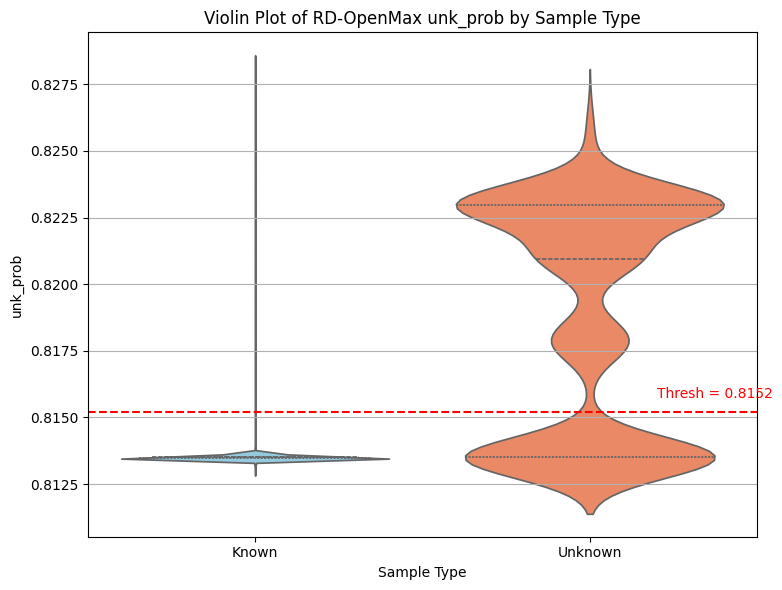

In [22]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

# Chuẩn bị DataFrame
df_violin = pd.DataFrame({
    'unk_prob': np.concatenate([unk_known, unk_unknown]),
    'type': ['Known'] * len(unk_known) + ['Unknown'] * len(unk_unknown)
})

plt.figure(figsize=(8, 6))
sns.violinplot(data=df_violin, x='type', y='unk_prob', inner='quartile', palette=['skyblue', 'coral'])

# Threshold
plt.axhline(best_thresh, color='red', linestyle='--')
plt.text(plt.xlim()[1]-0.3, best_thresh + 0.0005, f"Thresh = {best_thresh:.4f}", color='red')

plt.title("Violin Plot of RD-OpenMax unk_prob by Sample Type")
plt.ylabel("unk_prob")
plt.xlabel("Sample Type")
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()



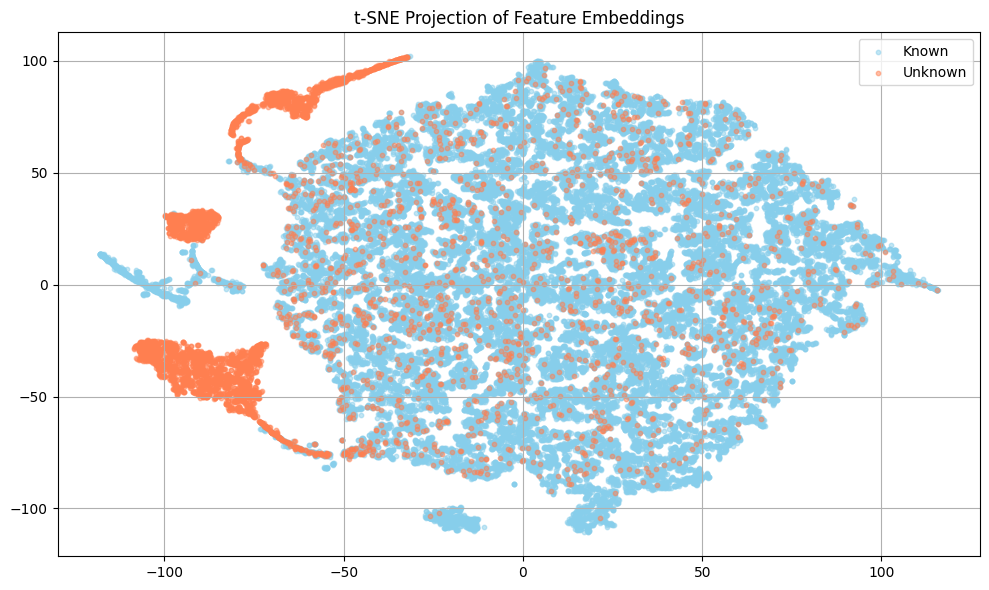

In [12]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# all_feat là embedding từ collect_scores
# all_labels_binary: 0 (known), 1 (unknown)

tsne = TSNE(n_components=2, random_state=42, perplexity=50)
proj = tsne.fit_transform(all_feat)

plt.figure(figsize=(10, 6))
plt.scatter(proj[all_labels_binary==0, 0], proj[all_labels_binary==0, 1],
            label='Known', alpha=0.5, color='skyblue', s=10)
plt.scatter(proj[all_labels_binary==1, 0], proj[all_labels_binary==1, 1],
            label='Unknown', alpha=0.5, color='coral', s=10)

plt.title("t-SNE Projection of Feature Embeddings")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
